## Week 5 - Semantic & Influence Networks 
Regina Catipon

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

In [140]:
# Grabbing data
news_data = pandas.read_csv("/Users/reginacatipon/Content-Analysis-2020/week-4/news_subset.csv")

In [141]:
news_data.shape

(1874, 5)

In [144]:
# subset corpus is still too large, grabbing a subset
sample_data = news_data[:100]

In [145]:
for i in range(len(sample_data['Text'])):
    sample_data['Text'][i] = sample_data['Text'][i].replace('<', "" ).replace('h>','')
         

/Users/reginacatipon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [146]:
sample_data['Text']

0     ##3527816  LiSA Blog 11/22/12 Ginkgo  Wow ? It...
1     ##3835511  Apparently was the case a few scene...
2     ##3836909  Seeking Excellent Advice About Cosm...
3     ##3529904  World News  Glencore-Xstrata Merger...
4     ##3836800  Am also inundated with rain in the ...
                            ...                        
95    ##3525711  Mohd Ismail : From Paperboy To Prop...
96    ##3527407  December 29 , 2005  In the middle o...
97    ##3529610  Yes , Virtua Fighter's Sarah and Pa...
98    ##3525002  Post navigation  Reaching Buyers wi...
99    ##3527800  linux-laptops.org  Menu  The way to...
Name: Text, Length: 100, dtype: object

In [147]:
# tokenize and normalize
sample_data['tokenized_sents'] = sample_data['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
sample_data['normalized_sents'] = sample_data['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/Users/reginacatipon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/reginacatipon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [148]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [185]:
# wordConcurrrence as base for network
g = wordCooccurrence(sample_data['normalized_sents'].sum())

In [195]:
print("Total number of vertices:", len(g.nodes))
print("Total number of edges:", len(g.edges))

Total number of vertices: 7690
Total number of edges: 144355


In [157]:
#g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [196]:
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [197]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [198]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 7601
Number of edges: 144331
Average degree:  37.9768


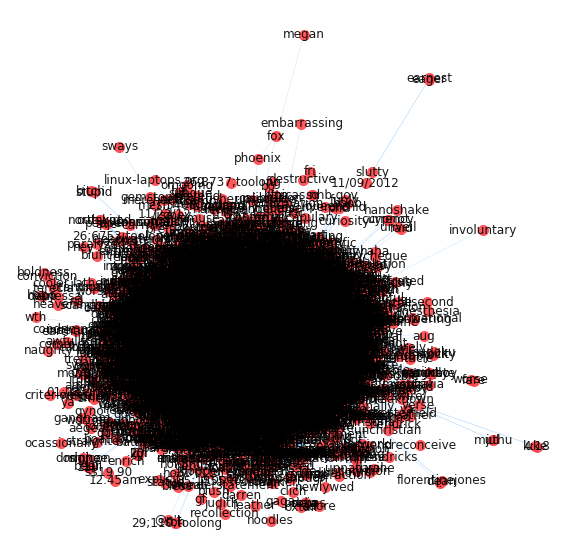

In [163]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

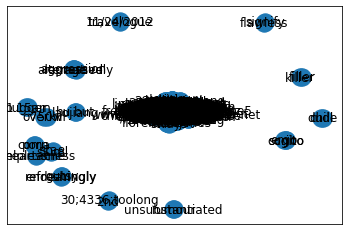

In [164]:
nx.draw_networkx(g)
plt.savefig("test.png")

In [165]:
# filtering out weights below 15
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 15])

In [166]:
# running again
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 3
Average degree:   2.0000


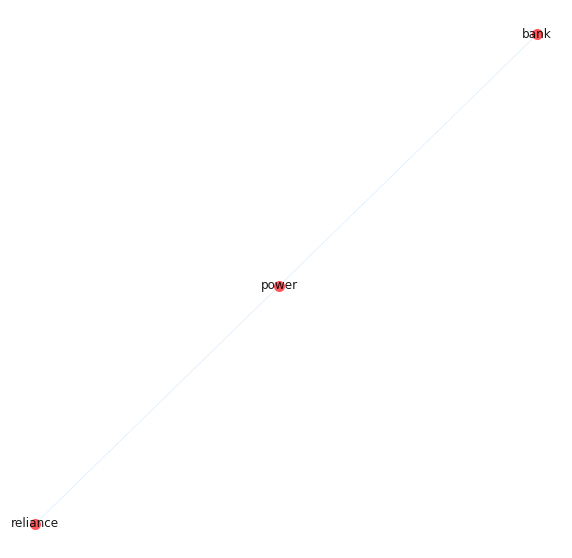

In [167]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Power is the central node to "bank" and "reliance"- a literal power structure, Foucault would be chuffed. :)

In [183]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

ZeroDivisionError: float division by zero

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [199]:
dcentralities = nx.degree_centrality(giant)

In [202]:
if 'money' in dcentralities.keys():
    print(True)

True


In [210]:
dcentralities['performance']

0.010789473684210526

In [204]:
max(dcentralities.items(), key = lambda x : x[1])

('time', 0.13710526315789473)

NetworkXError: Node 'performance' has no position.

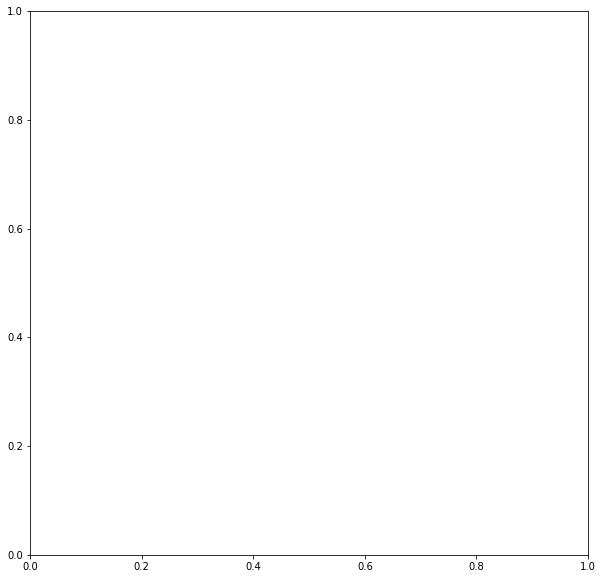

In [213]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

NameError: name 'gWord' is not defined

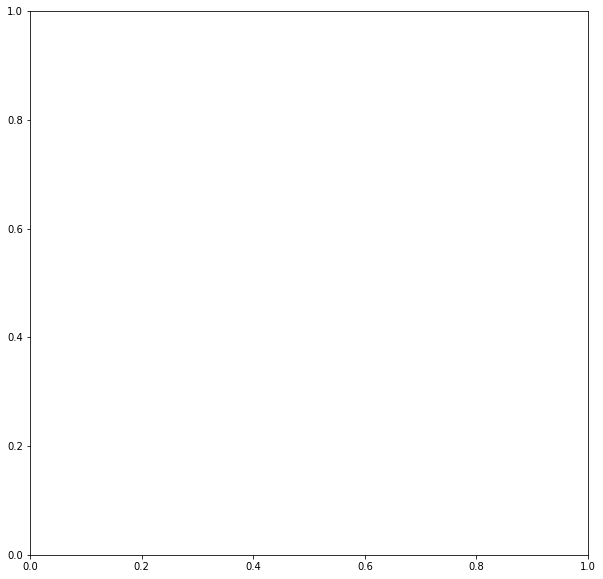

In [214]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

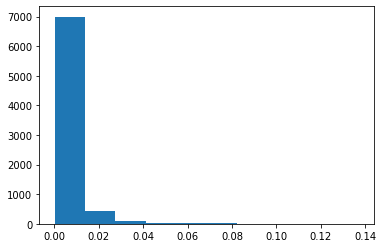

In [215]:
plt.hist(list(dcentralities.values()))
plt.show()

In [216]:
# Top ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('time', 0.13710526315789473),
 ('new', 0.12578947368421053),
 ('like', 0.12513157894736843),
 ('year', 0.12421052631578947),
 ('people', 0.11697368421052631),
 ('good', 0.10289473684210526),
 ('look', 0.0988157894736842),
 ('come', 0.09460526315789473),
 ('work', 0.09407894736842105),
 ('way', 0.09276315789473684)]

<span style="color:blue">We see that these words are time related... Common in journalism, seasonal</blue>



In [217]:
# Bottom ten words in terms of degree
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('cooler', 0.00013157894736842105),
 ('cal', 0.00013157894736842105),
 ('gemstone', 0.00013157894736842105),
 ('megan', 0.00013157894736842105),
 ('naughty', 0.00013157894736842105),
 ('frustrated', 0.00013157894736842105),
 ('ocassionally', 0.00013157894736842105),
 ('aegean', 0.00013157894736842105),
 ('gf', 0.00013157894736842105),
 ('noodles', 0.00013157894736842105)]

In [219]:
# Betweenness centrality distinguishes nodes that require the most 
# shortest pathways between all other nodes in the network.

bcentralities = nx.betweenness.betweenness_centrality(giant)

KeyboardInterrupt: 

In [ ]:
# checking the score for the previous top word
centralities['time']

In [ ]:
max(centralities.items(), key = lambda x : x[1])

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [ ]:
# Distribution plot
plt.hist(list(centralities.values()))
plt.show()

In [ ]:
# Top ten when it comes to betweenness centrality
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

It looks like the top words are centered on XX
